In [2]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf
from datasets import load_dataset
import numpy as np
import seaborn as sns
import pandas as pd


In [3]:
dataset = load_dataset("Kaludi/data-food-classification")
class_dict = {
    0: 'apple_pie',
    1: 'falafel',
    2: 'french_toast',
    3: 'ice_cream',
    4: 'ramen',
    5: 'sushi',
    6: 'tiramisu'
}



Resolving data files:   0%|          | 0/1052 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/352 [00:00<?, ?it/s]

In [4]:
def preprocess_image(example):
    from tensorflow.keras.preprocessing.image import img_to_array
    from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input 
    image = example['image'].resize((299,299))
    image = img_to_array(image)
    image = preprocess_input(image)
    return {"image": image, "label": example['label']}

dataset = dataset.map(preprocess_image, num_proc=1)
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((np.stack(dataset['train']['image']), np.array(dataset['train']['label']))).batch(batch_size).shuffle(1000).prefetch(tf.data.AUTOTUNE)
validation_dataset = tf.data.Dataset.from_tensor_slices((np.stack(dataset['validation']['image']), np.array(dataset['validation']['label']))).batch(batch_size).prefetch(tf.data.AUTOTUNE)



In [5]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
inputs = Input(shape=(299, 299, 3))
x = RandomFlip("horizontal")(inputs)
x = RandomRotation(0.1)(x)
#x = RandomZoom(0.2)(x)
#x = RandomContrast(0.2)(x)
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=x) 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
x = Dense(24, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)  
model = Model(inputs=inputs, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=[early_stopping])




Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.1155 - loss: 2.0023 - val_accuracy: 0.2371 - val_loss: 1.8956
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.2397 - loss: 1.8876 - val_accuracy: 0.3057 - val_loss: 1.8091
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.3123 - loss: 1.7855 - val_accuracy: 0.3914 - val_loss: 1.7043
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.3080 - loss: 1.7342 - val_accuracy: 0.5457 - val_loss: 1.5752
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.4793 - loss: 1.6031 - val_accuracy: 0.5914 - val_loss: 1.4606
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5472 - loss: 1.4879 - val_accuracy: 0.6886 - val_loss: 1.3431
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6151 - loss: 1.3677 - val_accuracy: 0.7086 - val_loss: 1.2561
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6430 - loss: 1.3085 - val_accuracy: 0

[Text(0.5, 1.0, 'Training and Validation Loss Curve'),
 Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Loss')]

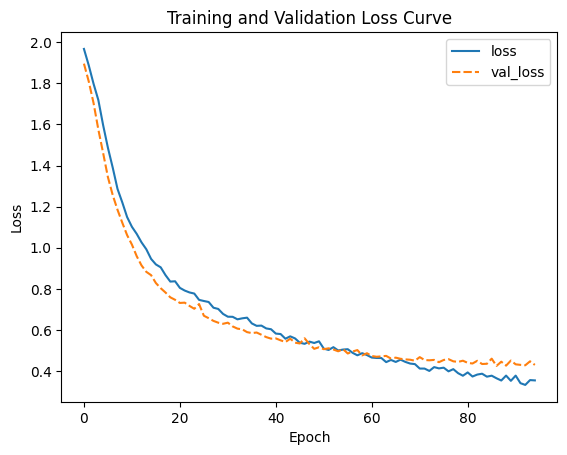

In [6]:
history_df = pd.DataFrame(history.history)
sns.lineplot(data=history_df[['loss','val_loss']]).set(title="Training and Validation Loss Curve", xlabel="Epoch", ylabel="Loss")

In [7]:
training_loss, training_accuracy = model.evaluate(train_dataset)
validation_loss, validation_accuracy = model.evaluate(validation_dataset)


print(f"Training Loss: {training_loss}, Training Accuracy: {training_accuracy}")
print(f"Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9039 - loss: 0.2976
22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8363 - loss: 0.4821
Training Loss: 0.32337653636932373, Training Accuracy: 0.8942857384681702
Validation Loss: 0.4249376058578491, Validation Accuracy: 0.8714285492897034
